In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1)

In [37]:
DATA_PATH = "data/"
TRAIN_DATA_FILE = "exoTrainData.npy"
TRAIN_LABELS_FILE = "exoTrainLabels.npy"
# TRAIN_DATA_UPSAMPLED_FILE = "exoTrainData_upsampled.npy"
# TRAIN_LABELS_UPSAMPLED_FILE = "exoTrainLabels_upsampled.npy"
TRAIN_DATA_UPSAMPLED_FILE = "newUpsampledXTrain.npy"
TRAIN_LABELS_UPSAMPLED_FILE = "newUpsampledYTrain.npy"
TEST_DATA_FILE = "exoTestData.npy"
TEST_LABELS_FILE = "exoTestLabels.npy"

x_train = np.load("{}{}".format(DATA_PATH, TRAIN_DATA_FILE))
y_train = np.load("{}{}".format(DATA_PATH, TRAIN_LABELS_FILE))
x_train_upsampled = np.load("{}{}".format(DATA_PATH, TRAIN_DATA_UPSAMPLED_FILE))
y_train_upsampled = np.load("{}{}".format(DATA_PATH, TRAIN_LABELS_UPSAMPLED_FILE))
x_test = np.load("{}{}".format(DATA_PATH, TEST_DATA_FILE))
y_test = np.load("{}{}".format(DATA_PATH, TEST_LABELS_FILE))

# TODO: actually get this in some time units so can set autopower arg more legitimately
t = np.arange(x_train.shape[1])

print(x_train.shape)
print(y_train.shape)
print(x_train_upsampled.shape)
print(y_train_upsampled.shape)
print(x_test.shape)
print(y_test.shape)

(5087, 3197)
(5087,)
(10082, 3197)
(10082,)
(570, 3197)
(570,)


In [38]:
from sklearn import metrics

def compute_metrics(clf, x_train, y_train, x_test, y_test, model_name=""):
    print("Accuracy on training data:", clf.score(x_train, y_train))
    print("Accuracy on test data:", clf.score(x_test, y_test))
    test_predicted_probs = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predicted_probs)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print("AUC:", metrics.auc(fpr, tpr))
    test_predicted = clf.predict(x_test)
    print("F1:", metrics.f1_score(y_test, test_predicted))
    print("Recall:", metrics.recall_score(y_test, test_predicted))
    print("Test prediction frequencies:")
    print(np.unique(test_predicted, return_counts=True))
    print("Confusion matrix:")
    cm = metrics.confusion_matrix(y_test, test_predicted)
    print(cm)
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, square=True, xticklabels=["without-exo", "with-exo"], yticklabels=["without-exo", "with-exo"])
    plt.gca().set_yticks([0.1, 1.2])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("{}_confusionmatrix.png".format(model_name), dpi=300, bbox_inches="tight")
    plt.show()
    sns.set(font_scale=1)

def compute_metrics_from_predictions(y_true, y_pred, y_pred_score=None, model_name=""):
    print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
    if y_pred_score is not None:
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
        print("Threshold range:", thresholds.min(), thresholds.max())
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        print("AUC:", metrics.auc(fpr, tpr))
    print("F1:", metrics.f1_score(y_true, y_pred))
    print("Recall:", metrics.recall_score(y_true, y_pred))
    print("Test prediction frequencies:")
    print(np.unique(y_pred, return_counts=True))
    print("Confusion matrix:")
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, square=True, xticklabels=["without-exo", "with-exo"], yticklabels=["without-exo", "with-exo"])
    plt.gca().set_yticks([0.1, 1.2])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("{}_confusionmatrix.png".format(model_name), dpi=300, bbox_inches="tight")
    plt.show()
    sns.set(font_scale=1)

# Box Least Squares SNR

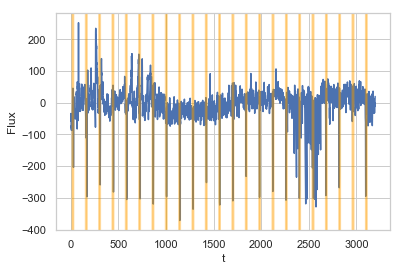

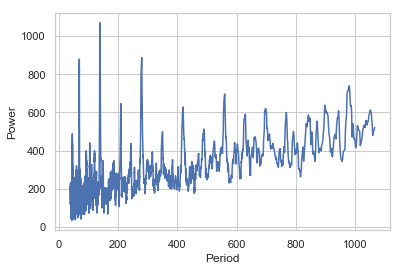

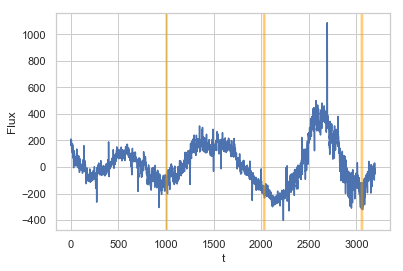

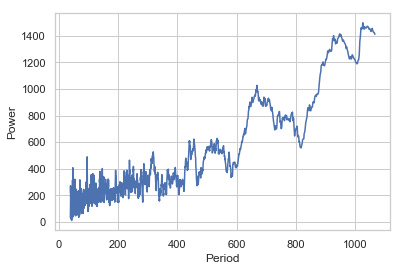

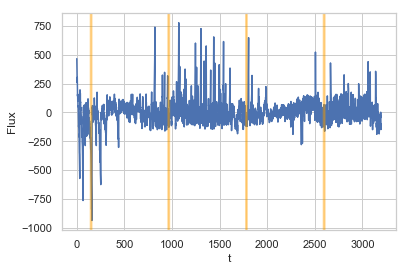

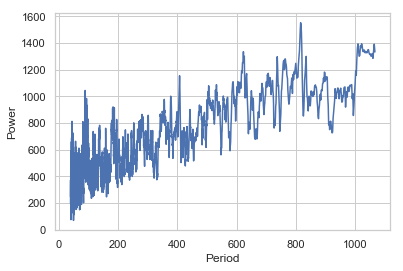

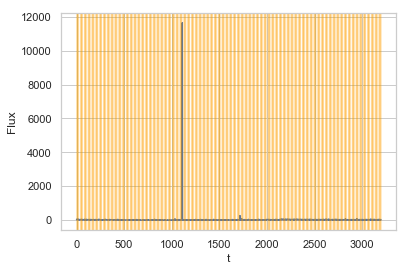

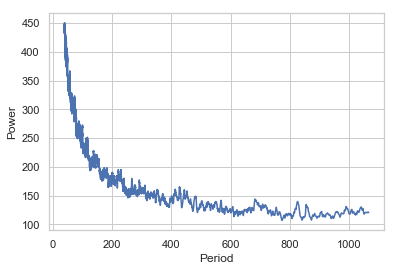

In [18]:
from astropy.stats import BoxLeastSquares

for i in [1, 5, 70, 71]:
    bls = BoxLeastSquares(t, x_train[i])
    periodogram = bls.autopower(20, minimum_n_transit=4, objective="snr")  # arg is the granularity of considered durations
    max_power = np.argmax(periodogram.power)
    mask = bls.transit_mask(t,
                            periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
    
    plt.plot(t, x_train[i])
    plt.xlabel("t")
    plt.ylabel("Flux")
    for ti in np.nonzero(mask)[0]:
        plt.axvline(ti, color="orange", alpha=0.06)
    plt.savefig("flux{}.png".format(i), dpi=300, bbox_inches="tight")
    plt.show()
    
    plt.plot(periodogram.period, periodogram.power)
    plt.xlabel("Period")
    plt.ylabel("Power")
    plt.savefig("periodogram{}.png".format(i), dpi=300, bbox_inches="tight")
    plt.show()

In [19]:
from astropy.stats import BoxLeastSquares

def get_bls_snr(x):
    snrs = []
    for i in range(x.shape[0]):
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(20, minimum_n_transit=4, objective="snr")  # arg is the granularity of considered durations
        max_power = np.argmax(periodogram.power)
        # based on https://arxiv.org/pdf/astro-ph/0206099.pdf
        snrs.append(periodogram.depth_snr[max_power])
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(snrs).reshape((-1, 1))

In [20]:
%%time

bls_snr_train = get_bls_snr(x_train)

KeyboardInterrupt: 

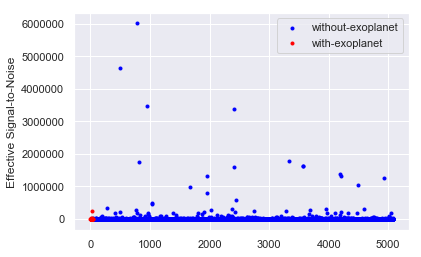

12.244975193456341
6029538.61968672


In [23]:
plt.scatter(np.arange(bls_snr_train.shape[0])[y_train==0], bls_snr_train.flatten()[y_train==0], marker='.', color="blue", label="without-exoplanet")
plt.scatter(np.arange(bls_snr_train.shape[0])[y_train==1], bls_snr_train.flatten()[y_train==1], marker='.', color="red", label="with-exoplanet")
plt.ylabel("Effective Signal-to-Noise")
plt.legend()
plt.savefig("bls_snr.png", dpi=300, bbox_inches="tight")
plt.show()
print(bls_snr_train.min())
print(bls_snr_train.max())

In [24]:
print(bls_snr_train[1], bls_snr_train[70])

[1069.2199266] [1550.77534472]


In [21]:
bls_snr_train_pred = bls_snr_train > 2e2
compute_metrics_from_predictions(y_train, bls_snr_train_pred, bls_snr_train, "blssnr_train")

NameError: name 'bls_snr_train' is not defined

In [22]:
bls_snr_test = get_bls_snr(x_test)

..................................................
.......


Accuracy: 0.4368421052631579
Threshold range: 28.52762284759409 1291829.953700316


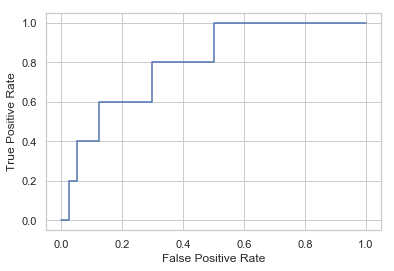

AUC: 0.800353982300885
F1: 0.030211480362537766
Recall: 1.0
Test prediction frequencies:
(array([False,  True]), array([244, 326], dtype=int64))
Confusion matrix:
[[244 321]
 [  0   5]]


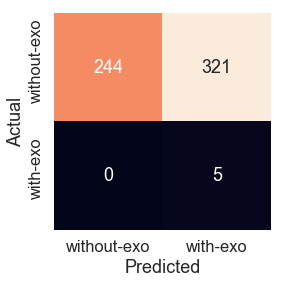

In [23]:
bls_snr_test_pred = bls_snr_test > 2e2
compute_metrics_from_predictions(y_test, bls_snr_test_pred, bls_snr_test, "blssnr_test")

# BLS with Logit

In [8]:
from astropy.stats import BoxLeastSquares

stat_names = ["depth", "depth_odd", "depth_even", "depth_half", "depth_phased"]

def get_bls_features(x):
    features = []
    for i in range(x.shape[0]):
        # adapted from http://docs.astropy.org/en/stable/stats/bls.html#peak-statistics
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(20, minimum_n_transit=4, objective="snr")  # arg is the granularity of considered durations
        max_power = np.argmax(periodogram.power)
        stats = bls.compute_stats(periodogram.period[max_power],
                                  periodogram.duration[max_power],
                                  periodogram.transit_time[max_power])
        features.append([stats[s][0] / stats[s][1] for s in stat_names])
        features[-1].extend([stats[s][0] for s in stat_names])
        features[-1].extend([stats[s][1] for s in stat_names])
        features[-1].append(periodogram.power[max_power])
        features[-1].append(periodogram.period[max_power])
        features[-1].append(periodogram.duration[max_power])
        features[-1].append(periodogram.transit_time[max_power])
        features[-1].append(periodogram.depth_snr[max_power])
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(features)

In [9]:
%%time

bls_train_features = get_bls_features(x_train_upsampled)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
...............................

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bls_train_features = scaler.fit_transform(bls_train_features)

In [11]:
from sklearn.linear_model import LogisticRegression

bls_logit = LogisticRegression()
bls_logit.fit(bls_train_features, y_train_upsampled)

C:\Users\czhao\Miniconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
print(bls_logit.coef_)
# print(bls_train_ratios.min(), bls_train_ratios.max())
# print("Ratio decision boundary:", -bls_logit.intercept_ / bls_logit.coef_)

# TODO: plot data with decision boundary

[[-0.8711434   2.53327445 -3.66301826  0.57520778  0.59874269  0.61858991
  -2.82990633  3.50267179 -0.18846693 -0.73475727  0.73426301  1.47740492
  -0.77875882 -5.36501615  1.22088686 -1.32655319  2.39335077  0.
  -0.29159704  1.04088642]]


In [13]:
bls_test_features = get_bls_features(x_test)

..................................................
.......


In [14]:
bls_test_features = scaler.transform(bls_test_features)

In [17]:
bls_logit.predict_proba(bls_test_features[:10])

array([[0.518571  , 0.481429  ],
       [0.73792551, 0.26207449],
       [0.55604465, 0.44395535],
       [0.36684466, 0.63315534],
       [0.38338437, 0.61661563],
       [0.71739234, 0.28260766],
       [0.34602935, 0.65397065],
       [0.29055482, 0.70944518],
       [0.69364304, 0.30635696],
       [0.80388409, 0.19611591]])

In [15]:
np.save("bls_train.npy", bls_train_features)
np.save("bls_test.npy", bls_test_features)

Accuracy on training data: 0.6219996032533227
Accuracy on test data: 0.5666666666666667


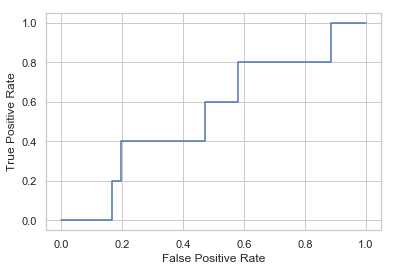

AUC: 0.5401769911504425
F1: 0.015936254980079684
Test prediction frequencies:
(array([0., 1.]), array([324, 246], dtype=int64))
Confusion matrix:
[[321 244]
 [  3   2]]


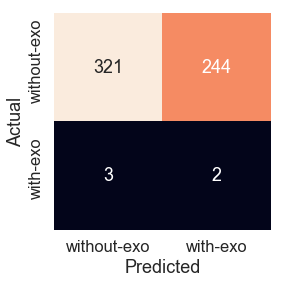

In [16]:
compute_metrics(bls_logit, bls_train_features, y_train_upsampled, bls_test_features, y_test, "blslogit_train")

# LSTM

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, CuDNNLSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential([
#     LSTM(16, input_shape=(x_train.shape[1], 1), dropout=0.2, recurrent_dropout=0.2),
#     Bidirectional(CuDNNLSTM(16, return_sequences=True)),
    Bidirectional(CuDNNLSTM(32, return_sequences=True)),
    Bidirectional(CuDNNLSTM(16)),
    Dense(16),
    Dropout(0.5),
    Dense(1),
    Activation("sigmoid"),
])
model.compile(optimizer=Adam(3e-4), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.FalseNegatives()])
x_train_lstm = x_train_upsampled[:, :, np.newaxis]
y_train_lstm = y_train_upsampled
x_test_lstm = x_test[:, :, np.newaxis]
y_test_lstm = y_test
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [56]:
%%time

N_EPOCHS = 5
BATCH_SIZE = 32

hist = model.fit(x_train_lstm, y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
train_losses.extend(hist.history["loss"])
test_losses.extend(hist.history["val_loss"])
train_accuracies.extend(hist.history["acc"])
test_accuracies.extend(hist.history["val_acc"])

Train on 10082 samples, validate on 570 samples
Epoch 1/5
10082/10082 [==============================] - 196s 19ms/sample - loss: 0.6495 - acc: 0.6175 - false_negatives_6: 1621.0000 - val_loss: 0.5398 - val_acc: 0.7053 - val_false_negatives_6: 2.0000
Epoch 2/5
10082/10082 [==============================] - 187s 19ms/sample - loss: 0.5614 - acc: 0.7223 - false_negatives_6: 1160.0000 - val_loss: 0.4787 - val_acc: 0.7614 - val_false_negatives_6: 2.0000
Epoch 3/5
10082/10082 [==============================] - 195s 19ms/sample - loss: 0.5095 - acc: 0.7538 - false_negatives_6: 994.0000 - val_loss: 0.4929 - val_acc: 0.7263 - val_false_negatives_6: 2.0000
Epoch 4/5
10082/10082 [==============================] - 517s 51ms/sample - loss: 0.4922 - acc: 0.7741 - false_negatives_6: 904.0000 - val_loss: 0.3536 - val_acc: 0.8298 - val_false_negatives_6: 3.0000
Epoch 5/5
10082/10082 [==============================] - 13748s 1s/sample - loss: 0.4923 - acc: 0.7739 - false_negatives_6: 926.0000 - val_los

In [42]:
model.save("lstm.h5")
np.save("lstm_loss", train_losses)
np.save("lstm_val_loss", test_losses)
np.save("lstm_acc", train_accuracies)
np.save("lstm_val_acc", test_accuracies)

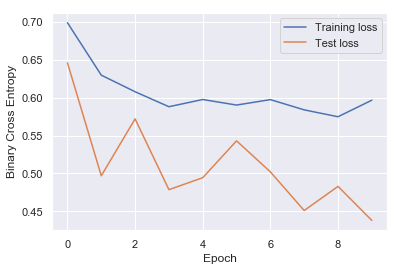

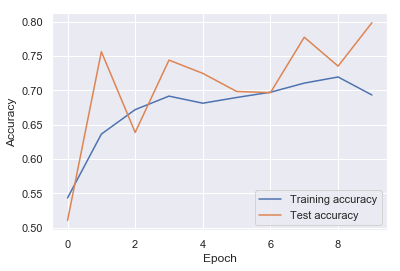

In [43]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")
plt.legend()
plt.savefig("lstm_loss.png", dpi=300, bbox_inches="tight")
plt.show()

plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("lstm_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
lstm_test_out = model.predict(x_test_lstm)

Accuracy: 0.7982456140350878
Threshold range: 0.049339503 1.9197686


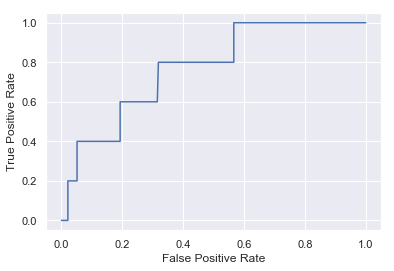

AUC: 0.7702654867256638
F1: 0.049586776859504134
Recall: 0.6
Test prediction frequencies:
(array([False,  True]), array([454, 116], dtype=int64))
Confusion matrix:
[[452 113]
 [  2   3]]


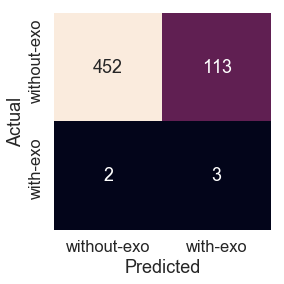

In [45]:
lstm_test_pred = lstm_test_out > 0.5
compute_metrics_from_predictions(y_test, lstm_test_pred, lstm_test_out, "lstm_test")

In [46]:
lstm_false_neg = np.nonzero((lstm_test_pred.flatten() == 0) & (y_test == 1))[0]
print(lstm_false_neg)
print(lstm_test_out[lstm_false_neg])
lstm_worst_false_neg = lstm_false_neg[np.argmin(lstm_test_out[lstm_false_neg])]
print(lstm_worst_false_neg)

[1 2]
[[0.41786736]
 [0.2532711 ]]
2


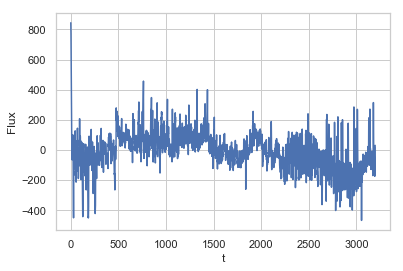

In [60]:
plt.plot(t, x_test[lstm_worst_false_neg])
plt.xlabel("t")
plt.ylabel("Flux")
plt.savefig("falseneg.png", dpi=300, bbox_inches="tight")
plt.show()

In [48]:
lstm_false_pos = np.nonzero((lstm_test_pred.flatten() == 1) & (y_test == 0))[0]
print(lstm_false_pos)
print(lstm_test_out[lstm_false_pos])
lstm_worst_false_pos = lstm_false_pos[np.argmax(lstm_test_out[lstm_false_pos])]
print(lstm_worst_false_pos)

[ 21  27  34  39  51  66  67  71  75  82  85 104 111 117 120 122 124 128
 136 137 142 145 146 147 150 153 156 164 169 175 178 181 183 189 209 213
 221 225 242 246 250 255 256 258 263 264 269 271 277 278 281 289 291 294
 301 318 319 322 325 326 329 334 339 340 344 346 363 364 366 367 369 383
 386 387 395 399 400 401 406 417 423 429 434 435 445 453 460 461 464 468
 470 471 474 476 480 486 487 495 496 498 506 508 509 511 525 535 539 540
 550 555 558 562 567]
[[0.5575584 ]
 [0.79276335]
 [0.53053105]
 [0.87996024]
 [0.5105813 ]
 [0.6952468 ]
 [0.5884668 ]
 [0.79253316]
 [0.65417004]
 [0.56736827]
 [0.5458687 ]
 [0.61162984]
 [0.5340698 ]
 [0.5620911 ]
 [0.59820575]
 [0.66070974]
 [0.67014223]
 [0.51646596]
 [0.5752519 ]
 [0.54439205]
 [0.73375344]
 [0.5938563 ]
 [0.5022444 ]
 [0.54533195]
 [0.536018  ]
 [0.59802985]
 [0.55756927]
 [0.55122954]
 [0.6273166 ]
 [0.571572  ]
 [0.67361873]
 [0.57309884]
 [0.6760847 ]
 [0.6408726 ]
 [0.5499965 ]
 [0.5067758 ]
 [0.5342124 ]
 [0.5666463 ]
 [0.5261

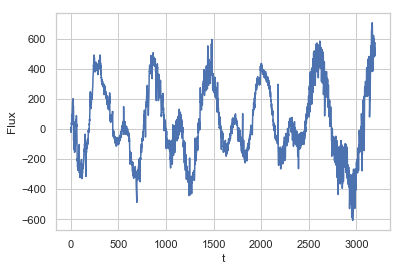

In [61]:
plt.plot(t, x_test[lstm_worst_false_pos])
plt.xlabel("t")
plt.ylabel("Flux")
plt.savefig("falsepos.png", dpi=300, bbox_inches="tight")
plt.show()